DSAA-2025 Tutorial Deep Leaning For Time Series Classification / Practical Time Series Classification: an Overview of Current Research and Solutions for Imperfect Data

# Deep learning based Time Series Machine Learning in `aeon`

Deep learning is proven to be very effective for Time Series Classification (TSC) tasks after the extensive experiments done in [[1]](#references), especially convolution based architectures (i.e. FCN and ResNet [[2]](#references)). A while later, InceptionTime (Convolution based) was proposed to become the new state-of-the-art deep learning model for TSC [[3]](#references). In [[4]](#references), new hand-crafted convolution filters were proposed to boost InceptionTime. The model proposed in [[4]](#references), Hybrid InceptionTime (H-InceptionTime) is currently, at the time of writing, the state-of-the-art deep learning model for TSC following [[5]](#references).

In this notebook, we cover the usage of the deep learning models for TSC tasks.

For all figures used in this demo, we use the one provided by the [Deep Learning for Time Series Classification webpage](https://msd-irimas.github.io/pages/dl4tsc/) with this reference figure for all legends needed:

__Note:__  All deep learners in `aeon` currently are based on `tensorflow`. You will need to `pip install tensorflow` to run this code.

<img src="https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/img/deep-legend.png?raw=1" alt="Deep Legend."><i>

# Table of Contents <a id='toc'></a>


* [Load example data](#load-data)
* [Simple Multiple Linear Perceptron (MLP)](#mlp)
    * [Using MLP for Classification](#mlp-usage)
* [Time Convolutional Neural Network (TimeCNN)](#time-cnn-network)
    * [Using TimeCNN for Classification](#time-cnn-usage)
* [Inception Based Networks](#inception-models)
    * [InceptionTime](#inceptiontime)
        * [Using InceptionTime for Classification](#inceptiontime-usage)
    * [Hybrid InceptionTime](#hinceptiontime)
        * [Using Hybrid InceptionTime for Classification](#hinceptiontime-usage)
    * [LITETime](#litetime)
        * [Using LITETime for Classification](#litetime-usage)
* [Performance on the UCR univariate classification datasets](#evaluation)
* [How to use Deep Learning on imperfect data ?](#imperfect)
    * [Unequal Length](#unequal)
    * [Class Imbalanced](#imbalanced)
* [References](#references)

In [ ]:
!pip install aeon==1.3.0 tensorflow
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSC_TEST.ts -P data/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


--2025-10-05 14:31:06--  https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TRAIN.ts
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367415 (359K) [text/plain]
Saving to: ‘data/KDD_MTSC_TRAIN.ts’

KDD_MTSC_TRAIN.ts   100%[===================>] 358.80K  --.-KB/s    in 0.03s   

2025-10-05 14:31:07 (10.5 MB/s) - ‘data/KDD_MTSC_TRAIN.ts’ saved [367415/367415]

--2025-10-05 14:31:07--  https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_MTSC_TEST.ts
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [ ]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from aeon.utils.discovery import all_estimators

all_estimators(
    type_filter="classifier", tag_filter={"algorithm_type": "deeplearning"}
)

[('DisjointCNNClassifier',
  aeon.classification.deep_learning._disjoint_cnn.DisjointCNNClassifier),
 ('EncoderClassifier',
  aeon.classification.deep_learning._encoder.EncoderClassifier),
 ('FCNClassifier', aeon.classification.deep_learning._fcn.FCNClassifier),
 ('InceptionTimeClassifier',
  aeon.classification.deep_learning._inception_time.InceptionTimeClassifier),
 ('IndividualInceptionClassifier',
  aeon.classification.deep_learning._inception_time.IndividualInceptionClassifier),
 ('IndividualLITEClassifier',
  aeon.classification.deep_learning._lite_time.IndividualLITEClassifier),
 ('LITETimeClassifier',
  aeon.classification.deep_learning._lite_time.LITETimeClassifier),
 ('MLPClassifier', aeon.classification.deep_learning._mlp.MLPClassifier),
 ('ResNetClassifier',
  aeon.classification.deep_learning._resnet.ResNetClassifier),
 ('TimeCNNClassifier',
  aeon.classification.deep_learning._cnn.TimeCNNClassifier)]

<a id='load-data'></a>
## Load example data

### EEG Classification <a id="eeg-classification-data"></a>

In [ ]:
from aeon.datasets import load_from_ts_file

X_train_c, y_train_c = load_from_ts_file("./data/KDD_UTSC_TRAIN.ts")
X_test_c, y_test_c = load_from_ts_file("./data/KDD_UTSC_TEST.ts")

# znormalize the series
X_train_c = (X_train_c - X_train_c.mean(axis=-1, keepdims=True)) / (X_train_c.std(axis=-1, keepdims=True))
X_test_c = (X_test_c - X_test_c.mean(axis=-1, keepdims=True)) / (X_test_c.std(axis=-1, keepdims=True))

print("Train shape:", X_train_c.shape)
print("Test shape:", X_test_c.shape)

Train shape: (40, 1, 100)
Test shape: (40, 1, 100)


(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

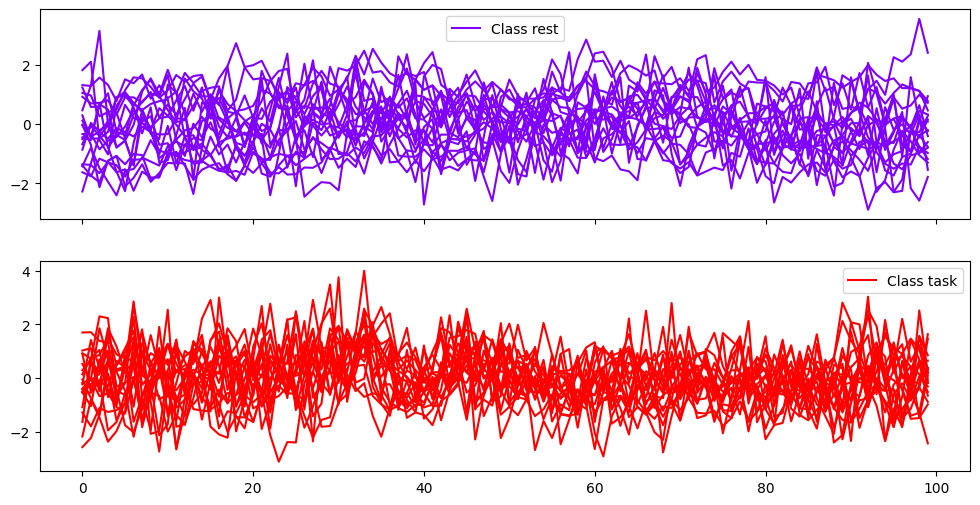

In [ ]:
from aeon.visualisation import plot_collection_by_class

plot_collection_by_class(X_train_c[:,0,:], y_train_c)

# Simple Multi Layer Perceptron (MLP) <a id='mlp'></a>

The Multilayer Perceptron (MLP) [[2]](#references), the simplest model in neural networks, is often used as a baseline for deep learning models. However, when applied to time series data, it fails to account for temporal dependencies. The MLP model tries to find the optimal non-linear combination of input features to achieve a good performance of a downstream task.

<img src="https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/img/MLP.png?raw=1" alt="mlp"><i>

## Using MLP for Classification <a id='mlp-usage'></a>

In [ ]:
from aeon.classification.deep_learning import MLPClassifier
from sklearn.metrics import accuracy_score

mlp_cls = MLPClassifier(n_epochs=100)
mlp_cls.fit(X_train_c, y_train_c)
mlp_cls_preds = mlp_cls.predict(X_test_c)
print(accuracy_score(y_test_c, mlp_cls_preds))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.55


## The Time Convolutional Neural Network (TimeCNN) <a id="time-cnn-network"></a>

The Time Convolutional Neural Network (TimeCNN) [[6]](#references) is a convolutional neural network where the optimization process focuses on learning the most effective filters to achieve optimal results. Unlike MLP, TimeCNN leverages local convolutions, allowing them to capture and consider temporal dependencies in the data, making them more suitable for time series analysis.

<img src="https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/img/TimeCNN.png?raw=1" alt="cnn"><i>

## Using TimeCNN for Classification <a id='time-cnn-usage'></a>

In [ ]:
from aeon.classification.deep_learning import TimeCNNClassifier
from sklearn.metrics import accuracy_score

# n_epochs chooses the number of training iterations
# verbose show the network's detail and the logs of training
cnn_cls = TimeCNNClassifier(n_epochs=500, verbose=True, save_best_model=True, best_file_name="best_cnn")
cnn_cls.fit(X_train_c, y_train_c)
cnn_cls_preds = cnn_cls.predict(X_test_c)
print(accuracy_score(y_test_c, cnn_cls_preds))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 94, 6)          │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 31, 6)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 12)         │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 8, 12)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758 (2.96 KB)

 Trainable params: 758 (2.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5000 - loss: 0.2721
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.2616
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.2545
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 0.2509
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4641 - loss: 0.2500
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5000 - loss: 0.2504
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5000 - loss: 0.2510
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5000 - loss: 0.2510
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5000 - loss: 0.2504
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.2497
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5125 - loss: 0.2492
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5969 - lo

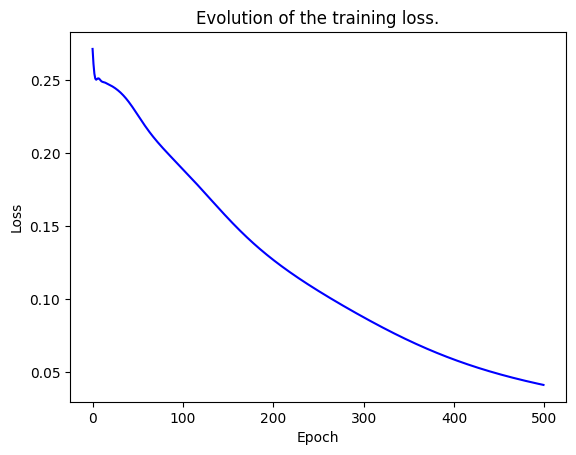

In [ ]:
import matplotlib.pyplot as plt

# you can retrieve the history of training to visualize the loss
loss = cnn_cls.history.history["loss"]
plt.plot(loss, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of the training loss.")
plt.show()

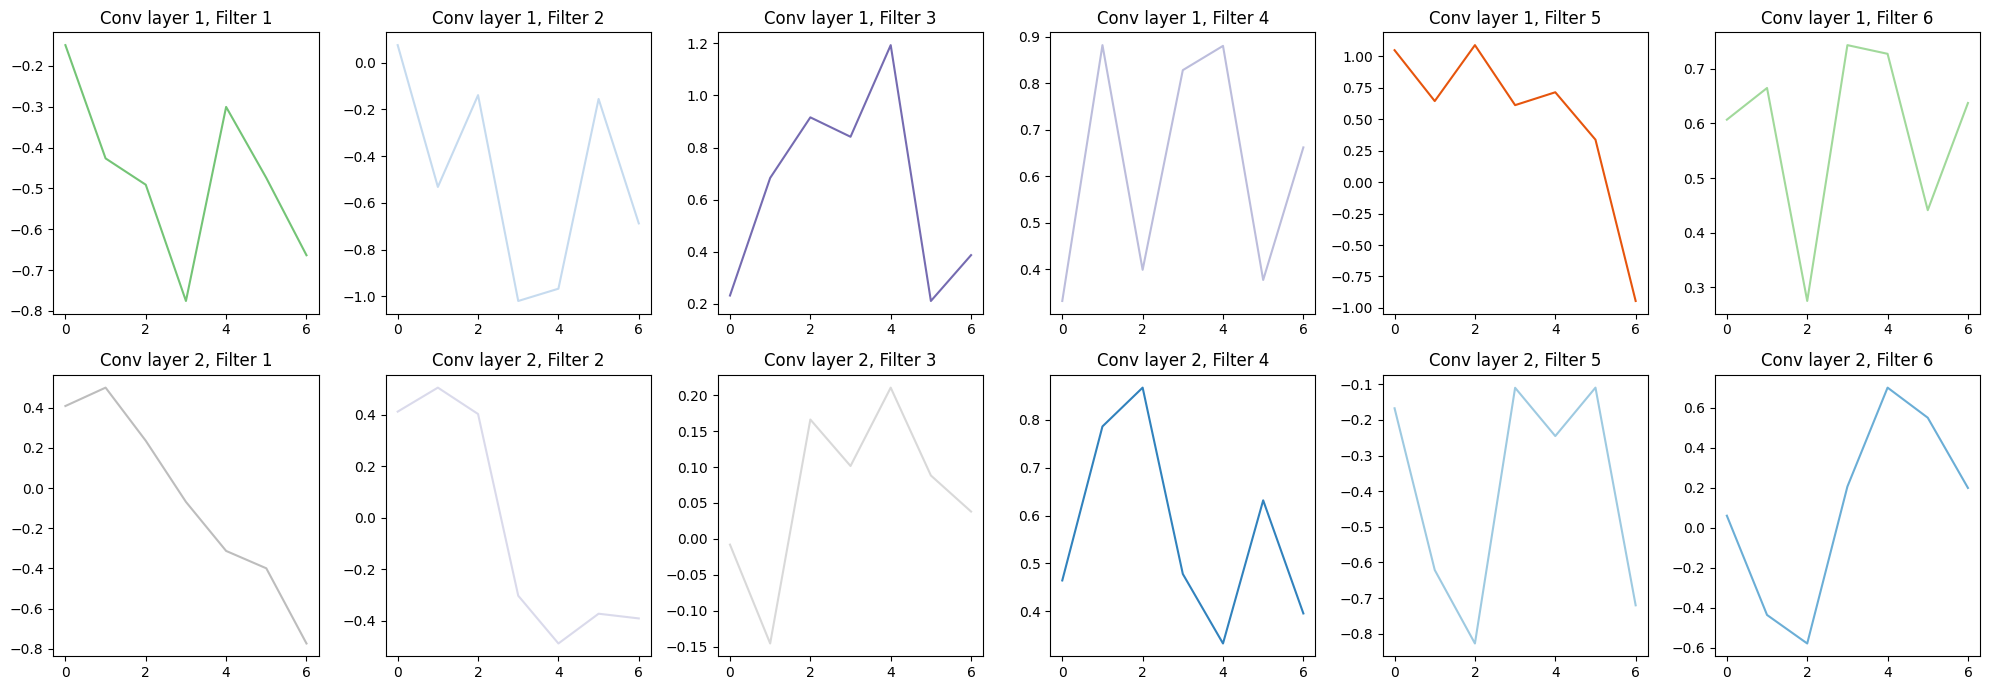

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

cnn_best = tf.keras.models.load_model("best_cnn.keras", compile=False)

#get conv weights of layer 1 (if you replace 0 by 1, you get the bias)
conv1_weights = cnn_best.layers[1].get_weights()[0]

#get conv weights of layer 2 (in TimeCNN, it corresponds to layer 3)
conv2_weights = cnn_best.layers[3].get_weights()[0]

fig,ax = plt.subplots(2,6,figsize=(20,7))

cmap = plt.get_cmap('tab20c')
values = np.linspace(0, 1, 18)
np.random.shuffle(values)

for i in range(6):
  ax[0,i].plot(conv1_weights[:,0,i],color=cmap(values[i]))
  ax[0,i].set_title('Conv layer 1, Filter ' + str(i+1))
  ax[1,i].plot(conv2_weights[:,0,i],color=cmap(values[6+i]))
  ax[1,i].set_title('Conv layer 2, Filter ' + str(i+1))
plt.tight_layout()
plt.show()

os.remove("best_cnn.keras")

## Inception Based Models <a id="inception-models"></a>

__Warning:__ The following models are computationally expensive and may take a long time to train on some setups (especially with no GPU).

### InceptionTime <a id="inceptiontime"></a>

InceptionTime [[3]](#references) is an ensemble of multiple Inception models, a convolution based neural network that leverages over TimeCNN by applying different convolution layers in parallel with different characteristics as well as using residual connections to avoid the vanishing gradient issue.

<img src="https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/img/InceptionTime.png?raw=1" alt="inctime"><i>

#### Using InceptionTime for Classification <a id='inceptiontime-usage'></a>

In [ ]:
from aeon.classification.deep_learning import InceptionTimeClassifier
from sklearn.metrics import accuracy_score

inceptiontime_cls = InceptionTimeClassifier(n_epochs=500)
inceptiontime_cls.fit(X_train_c, y_train_c)
inceptiontime_cls_preds = inceptiontime_cls.predict(X_test_c)
print("InceptionTime: ",accuracy_score(y_test_c, inceptiontime_cls_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
InceptionTime:  0.625


### Hybrid InceptionTime <a id="hinceptiontime"></a>

H-InceptionTime [[4]](#references) leverages over the InceptionTime model by adding some hand-crafted convolution filters at the beginning of the model. Such feature engineering technique helps the model generalize better to unseen cases.

<img src="https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/img/hcf.png?raw=1" style="width: 50%; height: auto; display: block; margin-left: auto; margin-right: auto;" alt="hcf"><i>

#### Using Hybrid InceptionTime for Classification
 <a id='hinceptiontime-usage'></a>

In [ ]:
from aeon.classification.deep_learning import InceptionTimeClassifier
from sklearn.metrics import accuracy_score

h_inceptiontime_cls = InceptionTimeClassifier(n_epochs=500, use_custom_filters=True)
h_inceptiontime_cls.fit(X_train_c, y_train_c)
h_inceptiontime_cls_preds = h_inceptiontime_cls.predict(X_test_c)
print("H-InceptionTime: ",accuracy_score(y_test_c, h_inceptiontime_cls_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
H-InceptionTime:  0.7


### LITETime <a id="litetime"></a>

LITETime [[7]](#references) is currently the smallest deep learning model that achieves state-of-the-art performance on TSC. It is based on the Inception architecture but with way less parameters to train while utilizing as well the hand-crafted convolution filters in the first layer.

<img src="https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/img/LITE.png?raw=1" alt="lite"><i>

#### Using LITETime for Classification <a id='litetime-usage'></a>

In [ ]:
from aeon.classification.deep_learning import LITETimeClassifier
from sklearn.metrics import accuracy_score

litetime_cls = LITETimeClassifier(n_epochs=500)
litetime_cls.fit(X_train_c, y_train_c)
litetime_cls_preds = litetime_cls.predict(X_test_c)
print("LITETime: ",accuracy_score(y_test_c, litetime_cls_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
LITETime:  0.65


## Performance on the UCR univariate classification datasets <a id='evaluation'></a>

Below we show the performance of the `MLP`, `InceptionTime` and `H-InceptionTime` deep learning models on the UCR TSC archive datasets [[4]](#references) using results from the TSC bake off in 2024 [[5]](#references).

In [ ]:
from aeon.benchmarking.results_loaders import get_estimator_results_as_array, get_estimator_results
from aeon.datasets.tsc_datasets import univariate
import pandas as pd

names = ["CNN", "InceptionTime", "H-InceptionTime", "LITETime", "1NN-DTW"]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape
df_results = pd.DataFrame(results, columns=names)

,CNN,InceptionTime,H-InceptionTime,LITETime,1NN-DTW
0,0.330000,0.910000,0.950000,0.900000,0.640000
1,0.365729,0.843990,0.841432,0.843990,0.603581
2,0.702857,0.862857,0.874286,0.828571,0.702857
3,0.733333,0.666667,0.700000,0.733333,0.633333
4,0.900000,0.850000,0.750000,0.750000,0.700000


(<Figure size 1000x600 with 1 Axes>, <Axes: >)

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


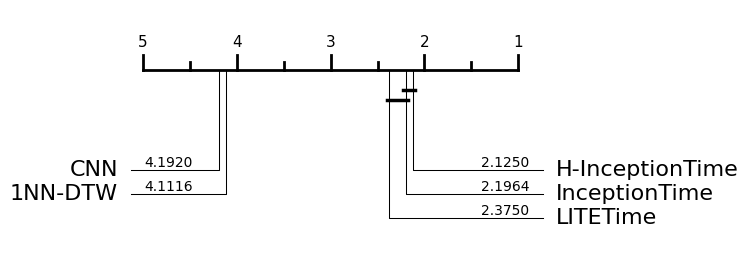

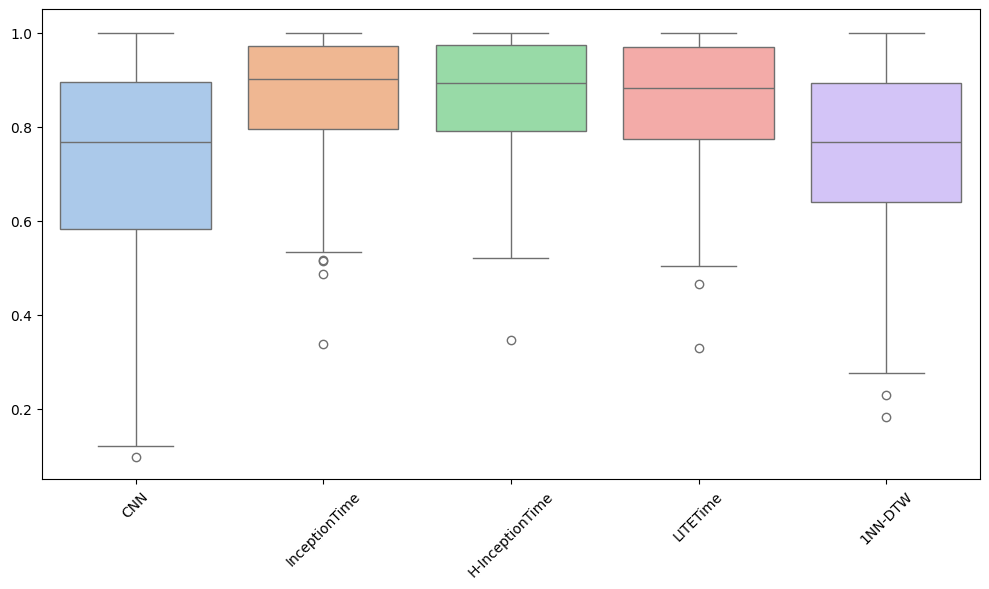

In [ ]:
from aeon.visualisation import plot_critical_difference
from aeon.visualisation import plot_boxplot
from aeon.visualisation import create_multi_comparison_matrix

plot_critical_difference(results, names)
plot_boxplot(results, names, plot_type="boxplot")

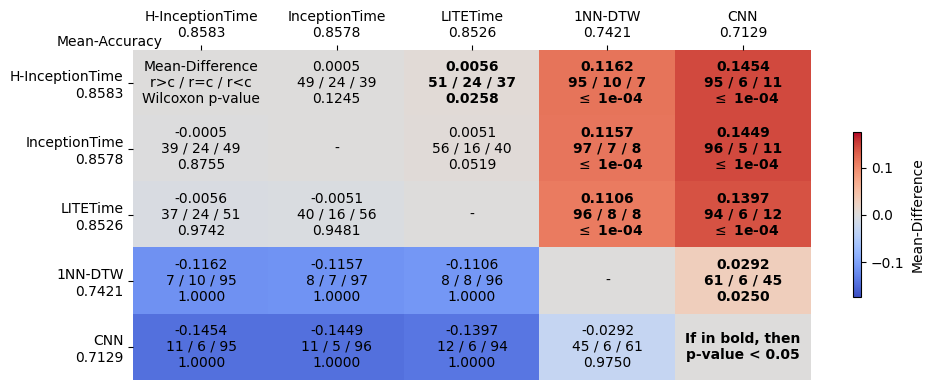

In [ ]:
create_multi_comparison_matrix(df_results, fig_size="10,4")
plt.show()

## How to use Deep Learning on imperfect data ? <a id='imperfect'></a>


In machine learning tasks it is common to stumble upon data that are imperfect in some sense. In this section we cover 2 common cases, the unequal length time series case and the class imbalanced case.

### Unequal Length

In real world application, it is common to end up on time series of different lengths. This can be due to different sampling rate, different cut off strategies etc. One specifity of deep learning models is that during training, a batch made of multiple series, should only contain time series samples of the same length. Two well known strategies are used by deep learning researchers: (1) prior padding and (2) online padding.

#### Loading an unequal length TSC dataset

min length:  80
max length:  360
mean length:  166
std length:  63


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

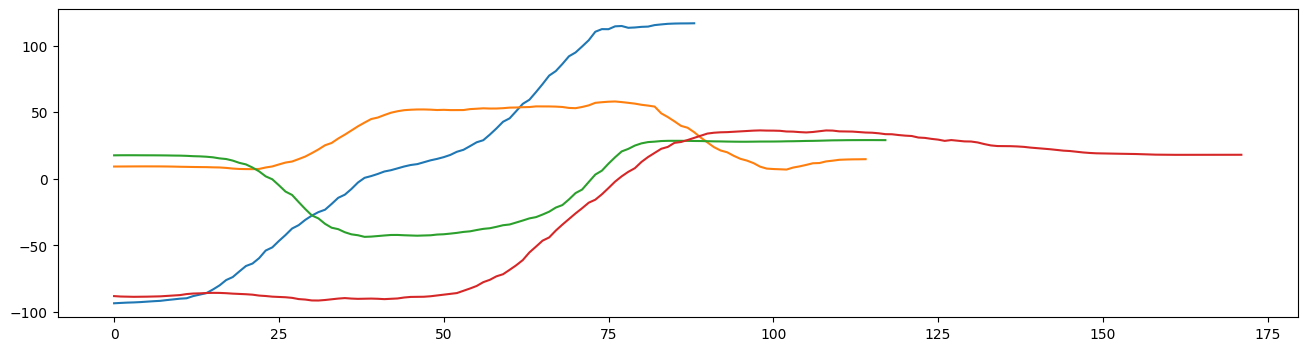

In [ ]:
from aeon.visualisation import plot_series_collection
from aeon.datasets import load_classification
import numpy as np

xtrain, ytrain = load_classification(name="GestureMidAirD1", split="train", load_equal_length=False)
xtest, ytest = load_classification(name="GestureMidAirD1", split="train", load_equal_length=False)

lengths = []
for x in xtrain:
  lengths.append(int(x.shape[-1]))
print("min length: ", np.min(lengths))
print("max length: ", np.max(lengths))
print("mean length: ", np.mean(lengths, dtype=int))
print("std length: ", np.std(lengths, dtype=int))

plot_series_collection([xtrain[0],xtrain[1],xtrain[2],xtrain[3]])

#### Prior Padding

Prior padding transforms all the time series in the dataset to the same length by simply padding all of the samples by a single value (commonly 0s) in order to have all of the samples to the same length of the longest one available. In order to do that in aeon we can simply use the padding transformer to transform our data and then run any deep learning estimator in aeon on the transformed data as we did on the previous examples.

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

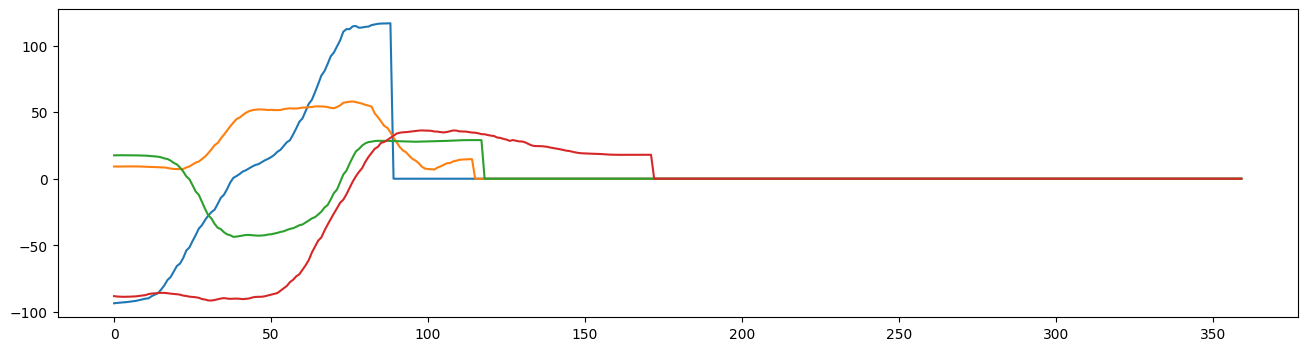

In [ ]:
from aeon.transformations.collection.unequal_length import Padder

padder = Padder(padded_length="max", fill_value=0)
xtrain_padded = padder.fit_transform(xtrain)

plot_series_collection(xtrain_padded[0:4])

#### Online Padding

There are multiple limitations with prior padding. For instance, if all of the series in the dataset are of length ranging from 20 to 30, with one single series of length 100, all of the series would be padded to the longest one, taking much more memory with no added value. Online padding is when we apply the padding to the longest in the batch during training. This avoids to always pad to the longest one in the dataset, reducing the amount of memory used and help the model generalize to see any given input length.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence


class PaddedBatchSequence(Sequence):
    def __init__(self, X_list, y_list, batch_size, shuffle=True):
        self.X = X_list
        self.y = np.array(y_list)
        self.batch_size = batch_size
        self.C = X_list[0].shape[0]
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X))
        self.on_epoch_end()

    def __len__(self):
        return (len(self.X) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.X))
        batch_idx = self.indices[low:high]

        batch_X = [self.X[i] for i in batch_idx]
        batch_y = self.y[batch_idx]

        max_T = max(x.shape[1] for x in batch_X)
        padded = np.zeros((len(batch_X), self.C, max_T), dtype=np.float32)
        for i, x in enumerate(batch_X):
            T = x.shape[1]
            padded[i, :, :T] = x

        padded = np.swapaxes(padded, axis1=1, axis2=2)

        return padded, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
from aeon.networks import LITENetwork
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


def convert_y_to_keras(y):
    """Convert y to required Keras format."""
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    classes_ = label_encoder.classes_
    n_classes_ = len(classes_)
    y = y.reshape(len(y), 1)
    # Adjustment to allow deprecated attribute "sparse for older versions
    import sklearn
    from packaging import version

    # Get the installed version of scikit-learn
    installed_version = sklearn.__version__
    # Compare the installed version with the target version
    # categories='auto' to get rid of FutureWarning
    if version.parse(installed_version) < version.parse("1.2"):
        onehot_encoder = OneHotEncoder(sparse=False)
    else:
        onehot_encoder = OneHotEncoder(sparse_output=False)
    y = onehot_encoder.fit_transform(y)
    return y

input_shape = (None, xtrain[0].shape[0])

ytrain_ohe = convert_y_to_keras(ytrain)
seq_train = PaddedBatchSequence(xtrain, ytrain_ohe, batch_size=64, shuffle=True)

input_layer, output_layer = LITENetwork().build_network(input_shape)
classification_layer = tf.keras.layers.Dense(units=len(np.unique(ytrain)), activation="softmax")(output_layer)

lite_unequal = tf.keras.models.Model(inputs=input_layer, outputs=classification_layer)
lite_unequal.compile(optimizer='adam', loss='categorical_crossentropy')

lite_unequal.fit(seq_train, epochs=500, batch_size=64)

Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 3.2818
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 3.2442
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 3.1865
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 3.1660
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 3.1297
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 3.1078
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 3.0536
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 3.0311
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 3.0238
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 3.0175
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 2.9722
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 2.9548
Epoch 13/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 2.9267
Epoch 14/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 2.8941
Epoch 15/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 2.8931
Epoch 16/500
4/4

In [ ]:
ytest_ohe = convert_y_to_keras(ytest)
seq_test = PaddedBatchSequence(xtest, ytest_ohe, batch_size=64, shuffle=False)

ypreds = lite_unequal.predict(seq_test)
ypreds = np.argmax(ypreds, axis=1)
ytest = np.argmax(ytest_ohe, axis=1)
print(accuracy_score(ytest, ypreds, normalize=True))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
0.8990384615384616


### Class Imbalanced

(181, 1, 900) (181,)


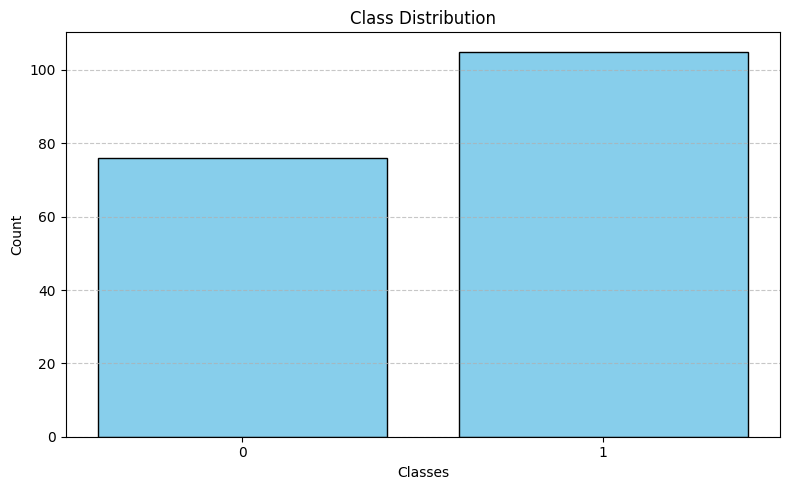

In [ ]:
from aeon.datasets import load_classification
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

xtrain, ytrain = load_classification(name="WormsTwoClass", split="train")
xtest, ytest = load_classification(name="WormsTwoClass", split="test")

le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

print(xtrain.shape, ytrain.shape)

train_classes, train_classes_freq = np.unique(ytrain, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar(train_classes, train_classes_freq, color='skyblue', edgecolor='black')
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(train_classes)  # ensure class labels show up
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from aeon.classification.deep_learning import TimeCNNClassifier
from sklearn.metrics import accuracy_score

clf = TimeCNNClassifier(n_epochs=100, verbose=1, random_state=42)
clf.fit(xtrain, ytrain)
ypreds = clf.predict(xtest)
print("TimeCNN performance on imabalanced data: ",accuracy_score(ytest, ypreds))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 900, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 894, 6)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_4             │ (None, 298, 6)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 292, 12)        │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 97, 12)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1164)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,894 (11.30 KB)

 Trainable params: 2,894 (11.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5024 - loss: 0.2617
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5135 - loss: 0.2673
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5611 - loss: 0.2480
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5553 - loss: 0.2479
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5611 - loss: 0.2496
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5611 - loss: 0.2464
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5582 - loss: 0.2471
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5582 - loss: 0.2456
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5559 - loss: 0.2445
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5579 - loss: 0.2434
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5633 - loss: 0.2418
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

In [ ]:
from numba import njit, prange


@njit(nopython=True, fastmath=True, parallel=True)
def window_warping(
    X: np.ndarray,
    y: np.ndarray = None,
    window_size_ratio: float = None,
    warp_scale: float = None,
    window_start: int = None,
):
    """Warp the input time series on the time axis.

    This augmentation method was proposed in [1]. The window size,
    warp scale and start of the window is randomly generated for each
    time series in the input batch, if and only if, the three parameters
    window_size_ration, warp_scale and window_start are set to None as
    by default. If these parameters are set to actual values then the same
    value is used all through the batch.

    Parameters
    ----------
    X: tf.Tensor, shape (batch_size, length_TS, n_channels)
        The input set of time series.
    y: np.ndarray, shape (batch_size,)
        The labels of each input time series. Ignored, here for
        code structure reasons.
    window_size_ratio: float, default = None
        The ratio size of the window to adjust by warping, if None,
        then it is randomly selected (between 5% and 30%) per
        series. If float, then the same value is used for all
        series in the batch.
    warp_scale: float, default = None
        The scale of the window warping, if None then it is randomly
        selected per series (between 0.5 and 2.0). If float, then
        the same value is used for all series in the batch.
    window_start: int, default = None
        The index of the start of the windows, if None then it is
        randomly selected per series. If in then the same value
        is used for all series in the batch.

    Returns
    -------
    np.ndarray, shape (batch_size, length_TS, n_channels)
        The warped series.

    References
    ----------
    [1] Le Guennec, Arthur, Simon Malinowski, and Romain Tavenard.
        "Data augmentation for time series classification using
        convolutional neural networks." In ECML/PKDD workshop on
        advanced analytics and learning on temporal data. 2016.
    """
    batch_size = len(X)
    n_channels = len(X[0])
    length_TS = len(X[0, 0])

    if window_size_ratio is None:
        window_size_ratios = np.random.choice(
            np.linspace(0.05, 0.3, num=6), size=batch_size
        )
    else:
        window_size_ratios = np.repeat(window_size_ratio, repeats=batch_size).reshape(
            (batch_size,)
        )
    window_sizes = np.ceil(window_size_ratios * length_TS).astype(np.int32)

    if warp_scale is None:
        warp_scales = np.random.choice(np.linspace(0.1, 2.0, num=20), size=batch_size)
    else:
        warp_scales = np.repeat(warp_scale, repeats=batch_size).reshape((batch_size,))

    warped_series = np.zeros_like(X)

    for i in prange(batch_size):
        _X = X[i]
        if window_start is None:
            _window_start = np.random.randint(
                low=1, high=length_TS - window_sizes[i], size=1
            )[0]
        window_end = _window_start + window_sizes[i]
        window_steps = np.arange(window_sizes[i])

        for dim in prange(n_channels):
            start_seg = _X[dim, :_window_start]
            window_seg = np.interp(
                np.linspace(
                    0, window_sizes[i] - 1, num=int(window_sizes[i] * warp_scales[i])
                ),
                window_steps,
                _X[dim, _window_start:window_end],
            )
            end_seg = _X[dim, window_end:]

            warped = np.concatenate((start_seg, window_seg, end_seg))

            warped_series[i, dim, :] = np.interp(
                np.arange(length_TS),
                np.linspace(0, length_TS - 1.0, num=len(warped)),
                warped,
            )

    return warped_series


def balance_with_augmentation(X, y, augment_fn):
    classes, counts = np.unique(y, return_counts=True)
    target = counts.max()

    X_bal = []
    y_bal = []

    for c in classes:
        mask = (y == c)
        X_c = X[mask]
        y_c = y[mask]
        n_c = len(X_c)

        X_bal.append(X_c)
        y_bal.append(y_c)

        need = target - n_c
        if need <= 0:
            continue

        n_repeat = need // n_c
        remainder = need % n_c

        for _ in range(n_repeat):
            out = augment_fn(X_c, y_c)
            X_aug = out[0] if isinstance(out, tuple) else out
            X_bal.append(X_aug)
            y_bal.append(np.full(n_c, c, dtype=y.dtype))

        if remainder > 0:
            X_small = X_c[:remainder]
            y_small = y_c[:remainder]
            out = augment_fn(X_small, y_small)
            X_aug_small = out[0] if isinstance(out, tuple) else out
            X_bal.append(X_aug_small)
            y_bal.append(np.full(remainder, c, dtype=y.dtype))

    X_bal = np.concatenate(X_bal, axis=0)
    y_bal = np.concatenate(y_bal, axis=0)
    return X_bal, y_bal


/usr/local/lib/python3.12/dist-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


(210, 1, 900) (210,)


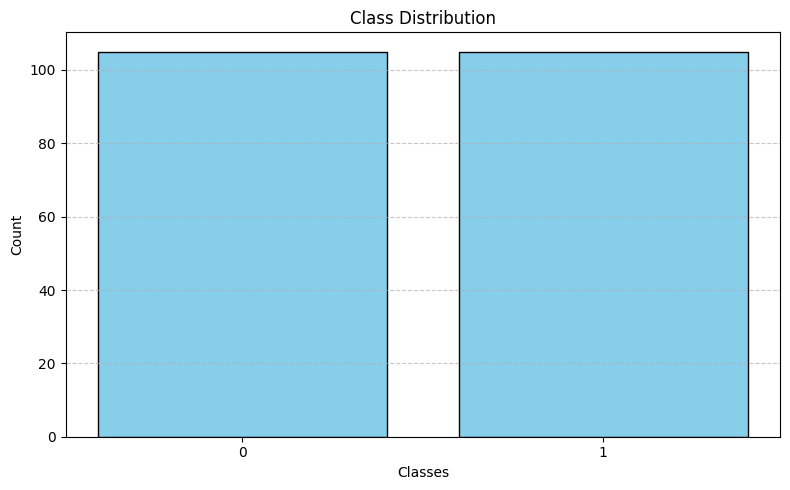

In [ ]:
xtrain_bal, ytrain_bal = balance_with_augmentation(xtrain, ytrain, window_warping)
print(xtrain_bal.shape, ytrain_bal.shape)

bal_train_classes, bal_train_classes_freq = np.unique(ytrain_bal, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar(bal_train_classes, bal_train_classes_freq, color='skyblue', edgecolor='black')
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(train_classes)  # ensure class labels show up
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
from aeon.classification.deep_learning import TimeCNNClassifier
from sklearn.metrics import accuracy_score

clf = TimeCNNClassifier(n_epochs=100, verbose=1, random_state=42)
clf.fit(xtrain_bal, ytrain_bal)
ypreds = clf.predict(xtest)
print("TimeCNN performance on balanced data: ",accuracy_score(ytest, ypreds))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 900, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 894, 6)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_6             │ (None, 298, 6)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 292, 12)        │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_7             │ (None, 97, 12)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1164)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,894 (11.30 KB)

 Trainable params: 2,894 (11.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4396 - loss: 0.2949
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4722 - loss: 0.2703
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4526 - loss: 0.2522
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4405 - loss: 0.2541
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4558 - loss: 0.2560
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4586 - loss: 0.2539
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4602 - loss: 0.2537
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4719 - loss: 0.2532
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4976 - loss: 0.2520
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5028 - loss: 0.2509
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5212 - loss: 0.2496
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
TimeCNN performance on balanced data:  0.5584415584415584


## References <a id='references'></a>

[1] Ismail Fawaz, Hassan, et al. "Deep learning for time series classification: a review." Data mining and knowledge discovery 33.4 (2019): 917-963.

[2] Wang, Zhiguang et al. "Time series classification from scratch with deep neural networks: A strong baseline." 2017 International joint conference on neural networks (IJCNN). IEEE, 2017.

[3] Ismail Fawaz, Hassan, et al. "Inceptiontime: Finding alexnet for time series classification." Data Mining and Knowledge Discovery 34.6 (2020): 1936-1962.

[4] Ismail-Fawaz, Ali, et al. "Deep Learning For Time Series Classification Using New Hand-Crafted Convolution Filters." International Conference on Big Data. IEEE, (2022).

[5] Middlehurst, Matthew, Patrick Schäfer, and Anthony Bagnall. "Bake off redux: a review and experimental evaluation of recent time series classification algorithms." Data Mining and Knowledge Discovery (2024): 1-74.

[6] Zhao et al. Convolutional neural networks for time series classification. Journal of Systems Engineering and Electronics 28.1 (2017)

[7] Ismail-Fawaz, Ali, et al. "Lite: Light inception with boosting techniques for time series classification." 2023 IEEE 10th International Conference on Data Science and Advanced Analytics (DSAA). IEEE, 2023.

[Return to Table of Contents](#toc)